In [3]:
from datasets import load_dataset, load_from_disk
import soundfile as sf
import os
import librosa
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

# 1. Data preparation
### Download data of <a href="https://huggingface.co/datasets/google/fleurs/tree/main/data/en_us">English</a>, <a href="https://huggingface.co/datasets/google/fleurs/tree/main/data/ar_eg">Arabic</a>, and <a href="https://huggingface.co/datasets/google/fleurs/tree/main/data/de_de">German</a> languages from <a href="https://huggingface.co/datasets/google/fleurs">Fleurs</a> dataset and save them locally

In [4]:
if not os.path.exists("./data"): 
    data_folder_paths = ["ar_eg", "en_us", "de_de"]
    for data_folder in data_folder_paths:
        # Specify the path where you want to download the folder contents
        download_path = "./data/" + data_folder +"/"
        # Load the dataset
        dataset = load_dataset("google/fleurs", data_folder)
        dataset.save_to_disk(download_path)

### Load the downloaded datasets

In [5]:
eng_dataset = load_from_disk("./data/en_us/")
arb_dataset = load_from_disk("./data/ar_eg/")
ger_dataset = load_from_disk("./data/de_de/")

### Get some insights about the data

In [6]:
mode = "train"    # ===================================> change between train, test, validation and run the cell below
# Define bins for duration 
bins = range(0, 30, 2)  # Bin size of 2 seconds

# Initialize empty lists for duration
durations_eng = []
# Loop through each WAV file in your dataset
for sample in eng_dataset[mode]:
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    durations_eng.append(duration)

durations_df = pd.DataFrame({"Duration":durations_eng, "Language":"eng"})

durations_arb = []  
for sample in arb_dataset[mode]:
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    durations_arb.append(duration)
    
durations_df2 = pd.DataFrame({"Duration":durations_arb, "Language":"arb"})
durations_df = pd.concat([durations_df, durations_df2], ignore_index=True)

durations_ger = []     
for sample in ger_dataset[mode]:
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    durations_ger.append(duration)
    
durations_df2 = pd.DataFrame({"Duration":durations_ger, "Language":"ger"})
durations_df = pd.concat([durations_df, durations_df2], ignore_index=True)

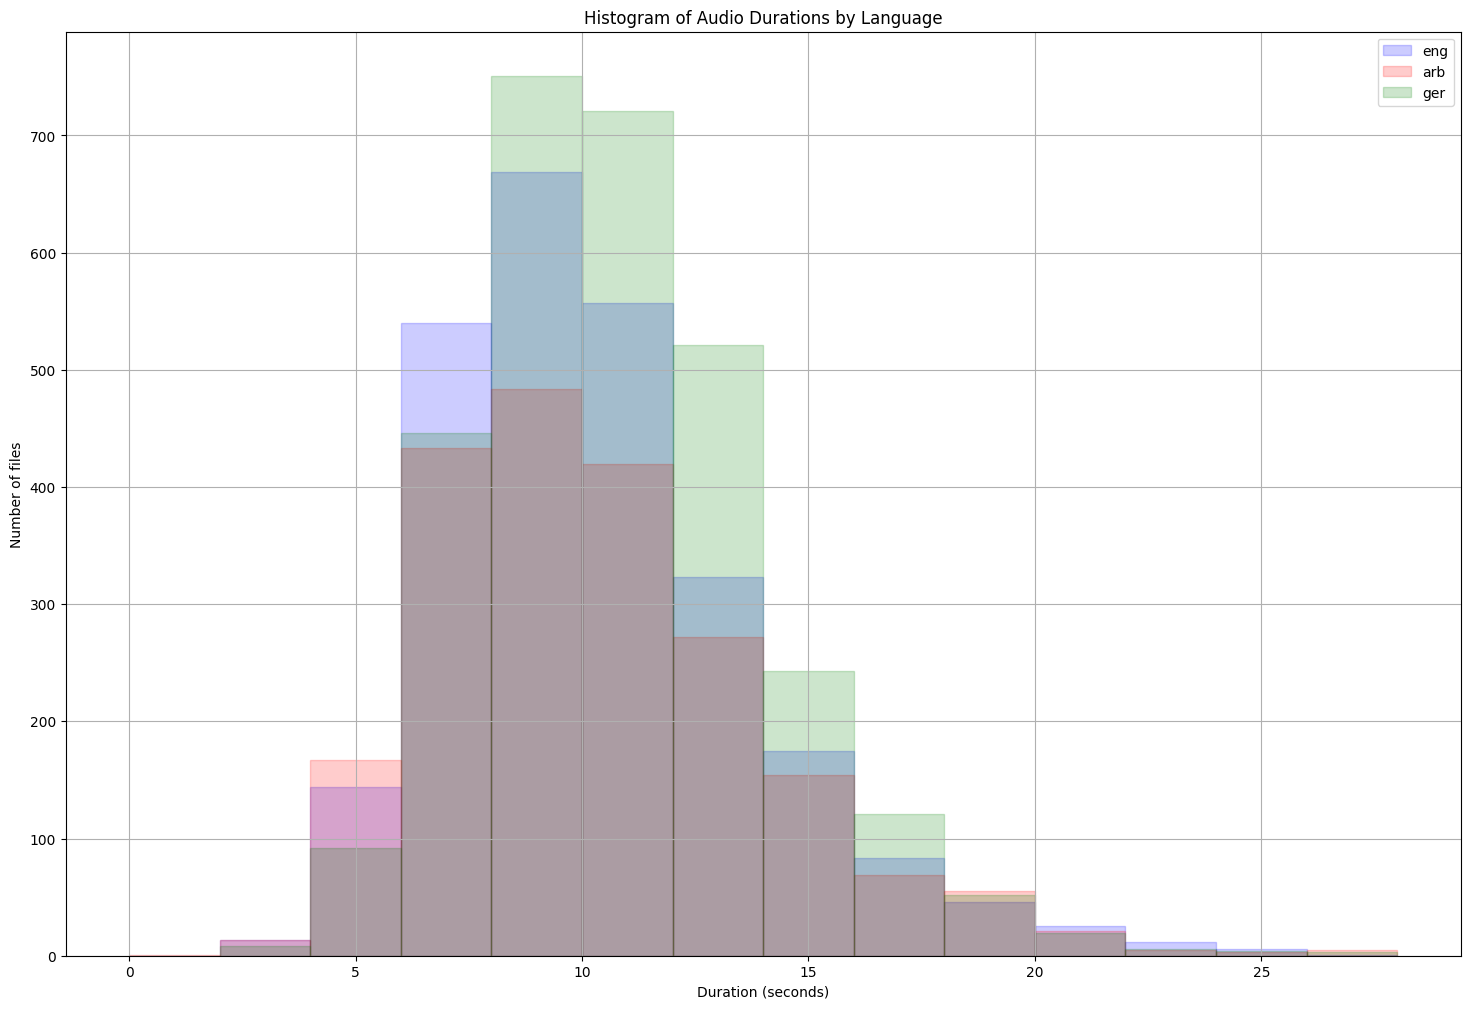

In [7]:
# Create the histogram plot
plt.figure(figsize=(18, 12))
plt.hist(durations_eng, bins, histtype='bar', color="blue", label="eng", alpha=0.2, edgecolor="blue")
plt.hist(durations_arb, bins, histtype='bar', color="red", label="arb", alpha=0.2, edgecolor="red")
plt.hist(durations_ger, bins, histtype='bar', color="green", label="ger", alpha=0.2, edgecolor="green")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of files")
plt.title("Histogram of Audio Durations by Language")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
durations_df.describe()

,Duration
count,7693.000000
mean,10.548216
std,3.532879
min,0.319063
25%,8.100000
50%,10.080000
75%,12.480000
max,42.360000


Remark:
- most of the data in the training set is concentrated at recordings in the range 6-14 seconds recording size
- the same could be said for testing except that of german language it is spread more towards longer recordings
- the validation is centralized in the range 6-12
- from the above description of the training dataset the mean duration is 10.5 and the std is 3.5 so if we take our range [6-14] we will have covered nearly 68% of the population with maintaining a reasonable recording size range

Conclusion:
- we will filter the dataset and take only recordings of durations in range 6-14 seconds

### Apply the filteration

In [9]:
MIN_RECORDING_SIZE = 6
MAX_RECORDING_SIZE = 14

In [10]:
eng_indices =[]
for index, sample in enumerate(eng_dataset["train"]):
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
        eng_indices.append(index)
        
arb_indices =[]
for index, sample in enumerate(arb_dataset["train"]):
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
        arb_indices.append(index)
        
ger_indices =[]
for index, sample in enumerate(ger_dataset["train"]):
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
        ger_indices.append(index)
        
print("English count: ",len(eng_indices), "\tArabic count: ", len(arb_indices), "\tGerman count: ", len(ger_indices))

English count:  2076 	Arabic count:  1587 	German count:  2431


# 1. HMM

### 1. get mel spectrogram

In [11]:
mfccs = {}  # Store extracted MFCCs
lengths = {}

mfccs_eng = []
for index in eng_indices:
  mfcc = librosa.feature.mfcc(y=eng_dataset["train"][index]["audio"]["array"], sr=eng_dataset["train"][index]["audio"]["sampling_rate"]).T
  mfccs_eng.append(mfcc)
mfccs["eng"] = np.vstack(mfccs_eng)

mfccs_arb = []
for index in arb_indices:
  mfcc = librosa.feature.mfcc(y=arb_dataset["train"][index]["audio"]["array"], sr=arb_dataset["train"][index]["audio"]["sampling_rate"]).T
  mfccs_arb.append(mfcc)
mfccs["arb"] = np.vstack(mfccs_arb)

mfccs_ger = []
for index in ger_indices:
  mfcc = librosa.feature.mfcc(y=ger_dataset["train"][index]["audio"]["array"], sr=ger_dataset["train"][index]["audio"]["sampling_rate"]).T
  mfccs_ger.append(mfcc)
mfccs["ger"]= np.vstack(mfccs_ger)

### 2. Train the  <a href="https://hmmlearn.readthedocs.io/en/latest/api.html#gmmhmm">HMMs</a>

In [16]:
num_iterations = 50
num_states = 40

In [17]:
models ={}
for language, mfccs_list in mfccs.items():
    # Train a model per language
    model = hmm.GMMHMM(n_components=num_states, n_iter=num_iterations, verbose=True)
    model.fit(mfccs[language])
    # Add the model to the dictionary
    models[language] = model

         1 -51587811.66401253             +nan
         2 -49755580.72005872 +1832230.94395381
         3 -49098005.59709793 +657575.12296078
         4 -48829769.33825964 +268236.25883829
         5 -48707329.85825430 +122439.48000535
         6 -48636526.73426648  +70803.12398782
         7 -48586158.23556409  +50368.49870239
         8 -48548408.75218279  +37749.48338130
         9 -48514890.32006404  +33518.43211875
        10 -48484461.46079595  +30428.85926808
        11 -48458983.20230760  +25478.25848836
        12 -48438481.10284939  +20502.09945820
        13 -48419173.42441202  +19307.67843737
        14 -48402442.23434657  +16731.19006545
        15 -48388776.10400479  +13666.13034178
        16 -48377361.29399671  +11414.81000807
        17 -48366464.44024626  +10896.85375045
        18 -48351542.40571391  +14922.03453235
        19 -48332068.31976245  +19474.08595146
        20 -48313454.46747807  +18613.85228437
        21 -48294540.59433447  +18913.87314361
        22 -

#### Save the trained models

In [18]:
# Create the directory if it doesn't exist
if not os.path.exists("./models"):
    os.makedirs("./models")
for language, model in models.items():
    with open("./models/"+language+".pkl", "wb") as file:
        pickle.dump(model, file)

#### Load the saved trained models

In [19]:
models2 = {}
for file_name in os.listdir("./models/"):
    if file_name.endswith(".pkl"):
        full_path = os.path.join("./models/", file_name)
        with open(full_path, "rb") as file:
            models2[file_name.split(".")[0]] = pickle.load(file)
print(models2)

{'arb': GMMHMM(covars_prior=array([[[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5,
         -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5,
         -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5,
         -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5...
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]]),
       n_components=40, n_iter=50, verbose=True,
       weights_prior=array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

### 3. Test the HMMs

In [20]:
eng_test_indices =[]
for index, sample in enumerate(eng_dataset["test"]):
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
        eng_test_indices.append(index)
        
arb_test_indices =[]
for index, sample in enumerate(arb_dataset["test"]):
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
        arb_test_indices.append(index)
        
ger_test_indices =[]
for index, sample in enumerate(ger_dataset["test"]):
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
        ger_test_indices.append(index)
        
print("English test count: ",len(eng_indices), "\tArabic test count: ", len(arb_indices), "\tGerman test count: ", len(ger_indices))

English test count:  2076 	Arabic test count:  1587 	German test count:  2431


In [21]:
label2number = {"eng":0,
                "arb":1,
                "ger":2}

In [22]:
def get_prediction(features, models_dictionary):
    scoreList = {}
    for model_label, model in models_dictionary.items():
        score = model.score(features)
        scoreList[model_label] = score
    predict = max(scoreList, key=scoreList.get)
    return label2number[predict]

In [23]:
true_labels = []
predicted_labels = []
# iterate through the test data and get the prediction and the true label
for index in eng_test_indices:
    mfcc = librosa.feature.mfcc(y=eng_dataset["test"][index]["audio"]["array"], sr=eng_dataset["test"][index]["audio"]["sampling_rate"]).T
    true_labels.append(0)
    predicted_labels.append(get_prediction(mfcc, models))
    
for index in arb_test_indices:
    mfcc = librosa.feature.mfcc(y=arb_dataset["test"][index]["audio"]["array"], sr=arb_dataset["test"][index]["audio"]["sampling_rate"]).T
    true_labels.append(1)
    predicted_labels.append(get_prediction(mfcc, models))
    
for index in ger_test_indices:
    mfcc = librosa.feature.mfcc(y=ger_dataset["test"][index]["audio"]["array"], sr=ger_dataset["test"][index]["audio"]["sampling_rate"]).T
    true_labels.append(2)
    predicted_labels.append(get_prediction(mfcc, models))

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

In [24]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy*100:.2f}%" )

Accuracy: 39.71%


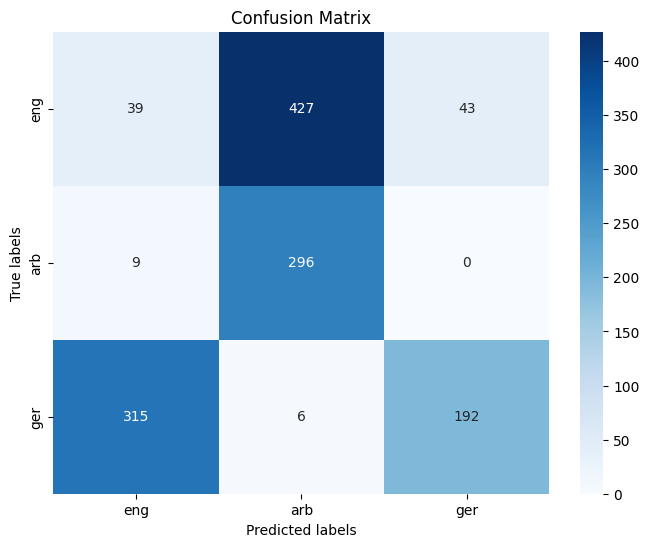

In [25]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['eng', 'arb', 'ger'], yticklabels=['eng', 'arb', 'ger'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

___
___
___
# Data prep for DL
before we proceed with LSTM we will create all the mfccs and store them so that we could load them directly rather than computing them each time

In [26]:
#TODO: Take only recordings that were taken in the hmm
MIN_RECORDING_SIZE = 6
MAX_RECORDING_SIZE = 14
root_path = "./mfccs2"

In [27]:
# create files if they dont exists
if not os.path.exists(root_path):
    for lang in ["eng", "arb","ger"]:
        os.makedirs(root_path+"/train/"+lang)
        os.makedirs(root_path+"/test/"+lang)
        os.makedirs(root_path+"/validation/"+lang)

In [28]:
dataset_lang = {"eng": eng_dataset,
                "arb": arb_dataset,
                "ger": ger_dataset}
max_length = 0
#outter loop per dataset 
for mode in ["train", "test","validation"]:
    #inner loop per language
    for language in ["eng", "arb", "ger"]:
        path = root_path+"/"+mode+"/"+language+"/"
        dataset_lang[language][mode]
        counter = 0
        for index, sample in enumerate(dataset_lang[language][mode]):
            duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
            if duration > MIN_RECORDING_SIZE and duration < MAX_RECORDING_SIZE:
                mf = librosa.feature.mfcc(y=sample["audio"]["array"], sr=sample["audio"]["sampling_rate"]).T
                filename = os.path.join(path, f"{counter}.npy")
                counter +=1
                np.save(filename, mf)
                if mf.shape[0] > max_length:
                    max_length = mf.shape[0]

In [19]:
print(max_length)

437


The max sequence length is 1499. we will use this as the input size and pad any smaller mfcc

___
___
___
# 2. LSTM
change the environment to the one with pytorch installed on

In [20]:
import os
import time
import copy
from datasets import load_dataset, load_from_disk
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
def get_files_count(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

### 1. Define a dataset class

In [22]:
class CustomDataset(Dataset):
    def __init__(self, path_to_mode, tensor_shape = (1499,20)):
        self.path_to_eng = path_to_mode + "/eng/"
        self.path_to_arb = path_to_mode + "/arb/" 
        self.path_to_ger = path_to_mode + "/ger/" 
        
        self.eng_files_count = get_files_count(self.path_to_eng)
        self.arb_files_count = get_files_count(self.path_to_arb)
        self.ger_files_count = get_files_count(self.path_to_ger)
        self.tensor_shape = tensor_shape
           
    def __len__(self):
        return self.eng_files_count + self.arb_files_count + self.ger_files_count

    def __getitem__(self, idx):
        if idx < self.eng_files_count:
            file_index = idx
            # Specify the filename
            filename = self.path_to_eng + f"{file_index}.npy"
            # Load the array from the file
            mfcc = np.load(filename)
            label = 0
        elif (idx >= self.eng_files_count) and (idx < (self.eng_files_count+self.arb_files_count)):
            file_index = idx - self.eng_files_count
            # Specify the filename
            filename = self.path_to_arb + f"{file_index}.npy"
            # Load the array from the file
            mfcc = np.load(filename)
            label = 1
        elif (idx >= (self.eng_files_count+self.arb_files_count)) and (idx < (self.eng_files_count+self.arb_files_count+self.ger_files_count)):
            file_index = idx - (self.eng_files_count+self.arb_files_count)
            # Specify the filename
            filename = self.path_to_ger + f"{file_index}.npy"
            # Load the array from the file
            mfcc = np.load(filename)
            label = 2
        else:
             raise IndexError(f"Index {idx} is out of range for array of length {self.__len__()}")
         
        # Pad the array with zeros to match the predefined shape
        padded_array = np.pad(mfcc, [(0, self.tensor_shape[0] - mfcc.shape[0]), 
                                     (0, self.tensor_shape[1] - mfcc.shape[1])], 
                      mode='constant')
        # Convert the padded array to a PyTorch tensor
        tensor_from_array = torch.tensor(padded_array, dtype=torch.float32)
        label = torch.tensor(label)
        
        return tensor_from_array, label

In [23]:
batch_size = 100
shuffle = True
desired_shape = (437, 20)
data_root_path = "./mfccs2"

In [24]:
train_dataset = CustomDataset(data_root_path+"/train", desired_shape)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

val_dataset = CustomDataset(data_root_path+"/validation", desired_shape)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)

test_dataset = CustomDataset(data_root_path+"/test", desired_shape)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

#define a dictionary with the dataloaders
dataloaders ={"train":train_loader,
              "val":val_loader,
              "test":test_loader}

dataset_sizes = {'train':len(train_dataset),
                 'val': len(val_dataset),
                 "test":len(test_dataset)}

# Create an iterator from the DataLoader
train_iter = iter(dataloaders["train"])
# Get a batch of images without advancing the count
batch_mfccs, batch_labels = next(train_iter)
# Perform operations with the batch of images
print("Batch size: ", batch_mfccs.size(), "\nLables vector size: ", batch_labels.size())

Batch size:  torch.Size([100, 437, 20]) 
Lables vector size:  torch.Size([100])


In [25]:
print(dataset_sizes)

{'train': 6094, 'val': 724, 'test': 1327}


### 2. Define the network architecture

In [26]:
input_size = desired_shape[1]
sequence_length = desired_shape[0]

# Model Parameters
number_layers = 5
number_classes = 3

hidden_state_size = 512
bidirectional = False
drop_out = 0.5

In [27]:
class LSTM(nn.Module):
    def __init__(self,input_size, hidden_size ,number_layers, drop_out, bidirectional, number_classes):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.number_layers = number_layers
        
        self.drop_out = drop_out
        self.bidirectional = bidirectional
        self.number_classes = number_classes
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=number_layers, bidirectional=bidirectional, batch_first=True, dropout=drop_out)
        #                                                                                                                          x.shape -> (batch_size, sequence_length, input_size)   
        self.fc = nn.Linear(hidden_size*(2 if self.bidirectional else 1), number_classes)
        
    def forward(self,x):
        # create an initial hidden state, and cell state variables initiallized to zeros
        h0 = torch.zeros(self.number_layers*(2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.number_layers*(2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(device)
        out , _ = self.lstm(x,(h0,c0))
        # out.shape -> (batch_size, sequence_length, hidden_size*(2 if self.bidirectional else 1))
        # we need to take the hidden state of only the last time step for classification
        out = out[:,-1,:]
        out = self.fc(out)
        return out

In [28]:
model = LSTM(input_size, hidden_state_size, number_layers, drop_out, bidirectional, number_classes).to(device)

In [29]:
writer = SummaryWriter("./LSTM/logs")
writer.add_graph(model, (batch_mfccs.to(device)))

### 3. Training the model

In [30]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=100, print_frequency=100):
    print("*"*80, end='\n')
    val_error =[]
    train_error = []
    val_acc = []
    train_acc = []
    
    since = time.time() # ------------> to get the time taken by training----------------

    # ----------------- To save the weights of the model with the best accuracy----------
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    n_total_steps = len(dataloaders["train"])
    for epoch in range(num_epochs):
        if (epoch+1) % print_frequency == 0:
            print(f'Epoch {epoch+1}/{num_epochs} ===== Best accuracy reached: {best_acc*100:.4f}%')
            print('-' * 40)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            # 1. ------------------ Set the network mode---------------------------------
            """
                be aware that some layers have different behavior during train/evaluation
                (like BatchNorm, Dropout) so setting it matters.
            """
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            # ---------------------------------------------------------------------------

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for mfccs, labels in dataloaders[phase]:
                mfccs = mfccs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(mfccs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * mfccs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # For learning rate scheduling
            # if phase == "train":
            #     scheduler.step(best_acc) 


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if (epoch+1) % print_frequency == 0:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc*100:.4f}'+"%")
                
            
            if phase =="train":
                train_error.append(epoch_loss)
                train_acc.append(epoch_acc)
                # writer.add_scalar("training loss"+setup_description, epoch_loss, epoch*n_total_steps)
                # writer.add_scalar("training accuracy"+setup_description, epoch_acc, epoch*n_total_steps)
            elif phase == "val":
                val_error.append(epoch_loss)
                val_acc.append(epoch_acc)
                # writer.add_scalar("validation loss"+setup_description, epoch_loss, epoch*n_total_steps)
                # writer.add_scalar("validation accuracy"+setup_description, epoch_acc, epoch*n_total_steps)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep copy of the best model weights
        if (epoch+1) % print_frequency == 0:
            print("="*80, end='\n')   

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f"Best validation accuracy = {best_acc*100:4f} %")
    print(f"Training time {time_elapsed}")
    # writer.add_scalar("Best val Acc:"+setup_description, best_acc*100, epoch*n_total_steps)
    # writer.add_scalar("Training time"+setup_description, time_elapsed, epoch*n_total_steps)
    training_progress ={"train_acc":train_acc,
                        "train_err":train_error,
                        "val_acc":val_acc,
                        "val_err": val_error}

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_progress

In [31]:
# Training the model
epochs = 50
print_freq = 1
learning_rate = 0.0001

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0)
# lr_scheduler
lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15)


model, train_metrics = train_model(model, criterion, optimizer, lr_sched, dataloaders, dataset_sizes, epochs, print_freq)

********************************************************************************
Epoch 1/50 ===== Best accuracy reached: 0.0000%
----------------------------------------
train Loss: 1.0873 Acc: 38.6610%
val Loss: 1.1186 Acc: 28.3149%
Epoch 2/50 ===== Best accuracy reached: 28.3149%
----------------------------------------
train Loss: 1.0814 Acc: 39.9081%
val Loss: 1.0980 Acc: 29.0055%
Epoch 3/50 ===== Best accuracy reached: 29.0055%
----------------------------------------
train Loss: 1.0573 Acc: 38.7923%
val Loss: 1.0899 Acc: 42.9558%
Epoch 4/50 ===== Best accuracy reached: 42.9558%
----------------------------------------
train Loss: 1.0858 Acc: 38.5133%
val Loss: 1.1021 Acc: 28.3149%
Epoch 5/50 ===== Best accuracy reached: 42.9558%
----------------------------------------
train Loss: 1.0778 Acc: 39.8917%
val Loss: 1.0821 Acc: 28.3149%
Epoch 6/50 ===== Best accuracy reached: 42.9558%
----------------------------------------
train Loss: 0.8336 Acc: 61.6180%
val Loss: 1.2682 Acc: 39.50

In [32]:
# saving the model weights
File_name = "LSTM"
PATH = "./models/" + File_name + ".pth"
torch.save(model.state_dict(), PATH)

#### Plot the training vs val error

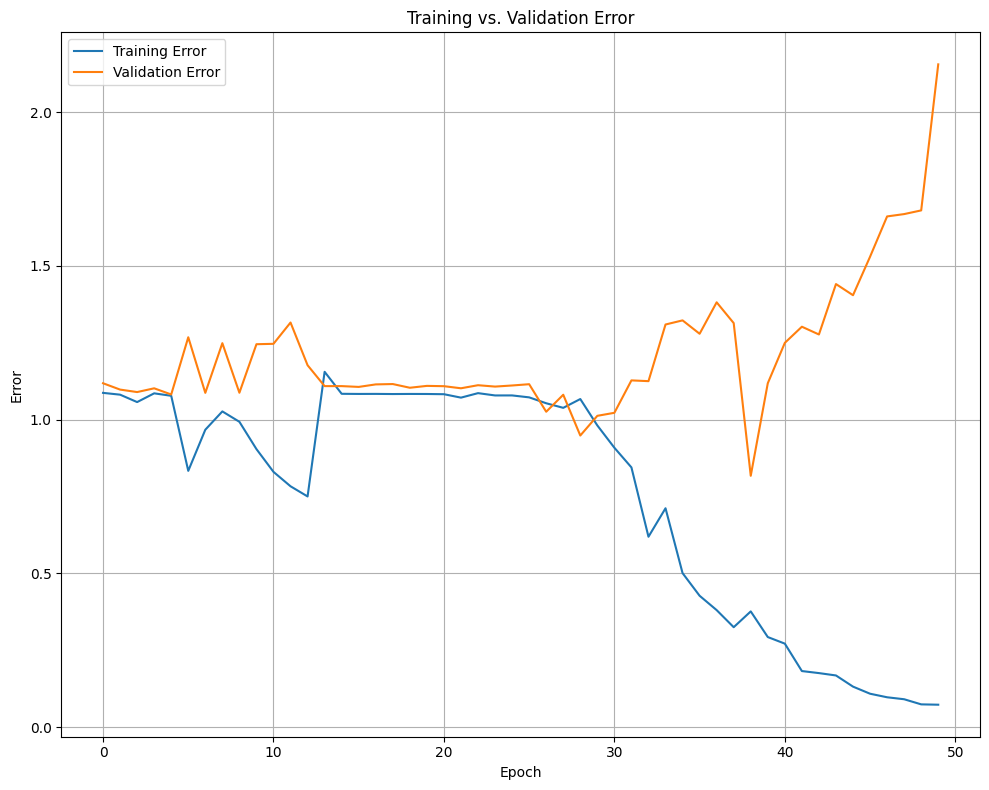

In [33]:
# Create the plot
plt.figure(figsize=(10, 8)) 

# Plot training errors
plt.plot(range(len(train_metrics["train_err"])), train_metrics["train_err"], label='Training Error')

# Plot validation errors
plt.plot(range(len(train_metrics["val_err"])), train_metrics["val_err"], label='Validation Error')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training vs. Validation Error')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

### 4. Testing the model

In [34]:
def test_model(model, test_dataloader):
    confusion_mat = dict()
    class_labels = []
    class_preds = []
    with torch.no_grad():
        model.eval()   # Set model to evaluate mode
        n_correct = 0
        n_samples = 0
        for mfccs, labels in test_dataloader:
            mfccs = mfccs.to(device)
            labels = labels.to(device)
            outputs = model(mfccs)
            
            # value, index
            _, prediction = torch.max(outputs, 1)
            n_samples += labels.shape[0]
            n_correct += (prediction == labels).sum().item()
            
            # calculate the propability of each class from the output
            class_probs_batch = [torch.nn.functional.softmax(output, dim=0) for output in outputs]

            class_preds.append(class_probs_batch)
            class_labels.append(labels)

        # 10000, 10, and 10000, 1
        # stack concatenates tensors along a new dimension
        # cat concatenates tensors in the given dimension
        class_preds = torch.cat([torch.stack(batch) for batch in class_preds])
        class_labels = torch.cat(class_labels)
        accuracy = n_correct/n_samples *100
        print(f"Test accuracy is {accuracy:.2f}%")

        _, class_preds = torch.max(class_preds, dim=1)    
        confusion_mat["actual"]=class_labels
        confusion_mat["prediction"]=class_preds
        
    plt.figure(figsize=(30, 26))
    confusion_matrix = metrics.confusion_matrix(confusion_mat["actual"].cpu(), confusion_mat["prediction"].cpu())
    
    # Normalize the confusion matrix
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='', annot_kws={"size": 20})
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
   # Set x-axis and y-axis labels from the list of labels
    lables = ["Eng", "Arb", "Ger"]
    plt.xticks(np.arange(len(list(lables))) + 0.5, lables, rotation=90)
    plt.yticks(np.arange(len(list(lables))) + 0.5, lables, rotation=0)


    plt.title(f'Confusion Matrix Test accuracy={accuracy:.2f}%')    
    plt.tight_layout()
    plt.show()

Test accuracy is 71.29%


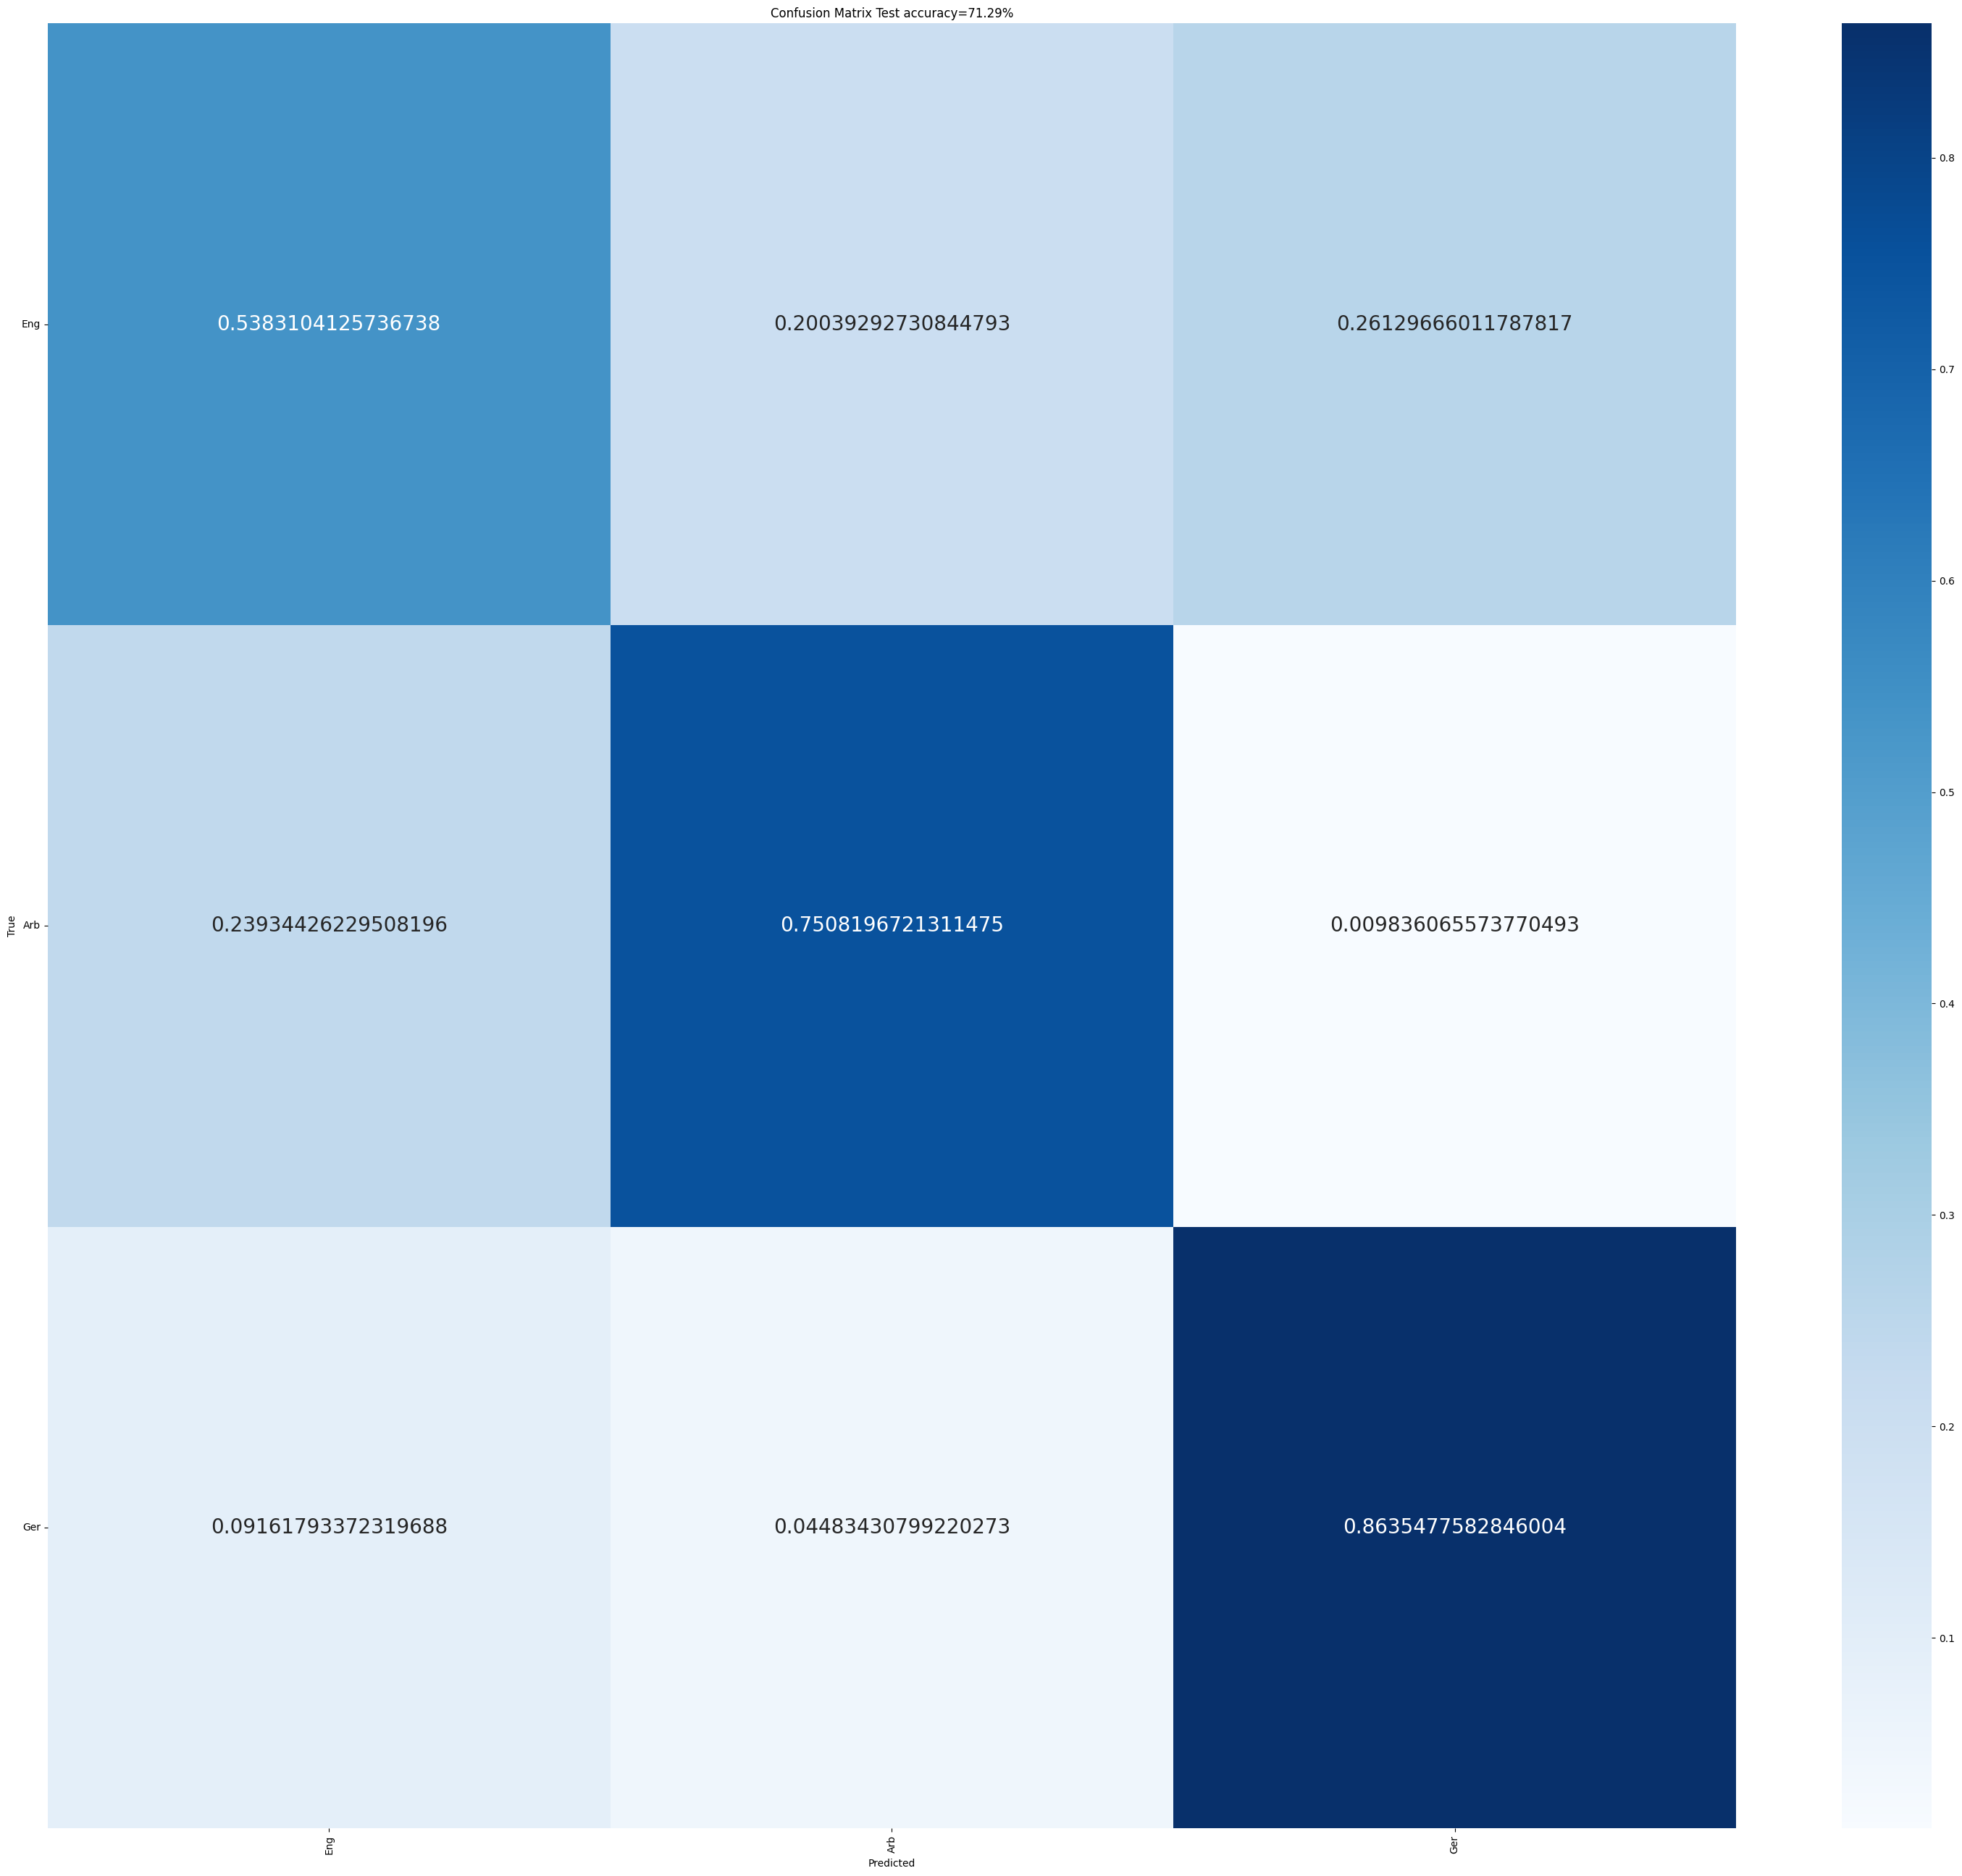

In [35]:
test_model(model, dataloaders["test"])

___
___
___
### Miscellaneous

In [36]:
print(eng_dataset)
eng_dataset["train"][0]

DatasetDict({
    train: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 2602
    })
    validation: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 394
    })
    test: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 647
    })
})


{'id': 903,
 'num_samples': 108800,
 'path': '/home/omar/.cache/huggingface/datasets/downloads/extracted/df06677640bb226713c3a6aff81764d1689d917047dd19fb221275271d0db817/10004088536354799741.wav',
 'audio': {'path': '10004088536354799741.wav',
  'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.15904617e-06, -3.03983688e-06, -3.27825546e-06]),
  'sampling_rate': 16000},
 'transcription': 'a tornado is a spinning column of very low-pressure air which sucks the surrounding air inward and upward',
 'raw_transcription': 'A tornado is a spinning column of very low-pressure air, which sucks the surrounding air inward and upward.',
 'gender': 1,
 'lang_id': 19,
 'language': 'English',
 'lang_group_id': 0}

In [37]:

def generate_wav(path, file_name, audio_data, sampling_rate):
    if not os.path.exists(path):
        os.makedirs(path)
    # Save the audio data as a WAV file
    sf.write(path+file_name, audio_data, sampling_rate)


In [38]:
generate_wav("./eng/","eng1.wav", eng_dataset["train"][0]["audio"]["array"], eng_dataset["train"][0]["audio"]["sampling_rate"])
generate_wav("./ger/","ger1.wav", ger_dataset["train"][0]["audio"]["array"], ger_dataset["train"][0]["audio"]["sampling_rate"])
generate_wav("./arb/","arb1.wav", arb_dataset["train"][0]["audio"]["array"], arb_dataset["train"][0]["audio"]["sampling_rate"])
